# Precipitation Frequency Table

__Description__: Auto-retrieve [NOAA Atlas 14](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_gis.html) precipitation statistics from [FTP](ftp://hdsc.nws.noaa.gov/pub/hdsc/data/) and calcualte the area-averaged precipitaiton frequency table for the area of interest (AOI).

__Input__: A vector polygon of the AOI, the NOAA Atlas 14 [volume](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html) number, and durations of interest.

__Output__: A spreadsheet with tabs for each duration. Each tab contains a table for the given duration with area-averaged precipitation and confidence limits.

---

## Load Libraries, Parameters, and Data:

### Libraries:

In [1]:
import sys
sys.path.append('core')
from hydromet import*
from hydromet_plotter import*

### Parameters: 

#### Papermill (site specific):

In [2]:
### Atlas 14 volume number:
volume = 10

### Vector polygon information (.geojson, .shp, or .gdb):
polygon = 'test.geojson'

root_dir = pl.Path(os.getcwd())
inputs_dir = root_dir/'Inputs'
polygon_dir = inputs_dir/polygon
outputs_dir = root_dir/'Outputs'


#### Global (project specific):

In [3]:
assert volume!= 5, 'For Volume 5 (Selected Pacific Islands) the user needs to specify as sub_volume ID, which needs to be adapted into the workflow'
volume_key = {1:'sw' , 2:'orb', 3:'pr', 4:'hi', 5:['nmi', 'ch', 'ko', 'pp', 'nk', 'pg', 'yp', 'wl', 'ul', 'pl', 'rm', 'as', 'gu', 'wki'], 6:'sw', 7:'ak', 8:'mw', 9:'se', 10:'ne', 11:'tx'}

noaa_data_crs = {'init':'epsg:4326'} 

# If geopandas cannot read the projection info, add proj4 string here
brute_force_projection=None

durations = ['06h', '12h', '24h', '04d'] 
dur_names = ['6hr', '12hr', '24hr', '96hr']

## Read Vector Polygon:

### Load as a geodataframe:

In [4]:
gdf = gpd.GeoDataFrame.from_file(polygon_dir)
gdf.head(2)

,HUC_8,OBJECTID_1,ID,HUC_89,RISK_FACTO,RISK_RANK,RISK_DECIL,RISKPCT,RANK_NO,Shape_Leng,Shape_Area,Scope_Mile,geometry
0,02010006,0,0.0,None,0.0,0.0,0.0,None,0.0,3.708098,0.17945,177.1,"(POLYGON ((-73.9083514 44.36842019999995, -73...."


### Add filtering if desired

In [5]:
filter_field = 'HUC_8'        # Attribute with in the vector polygon used for data selection
select_data = '02010006'  # Value within the filter_field used for data selection
gdf_slice_column = 'HUC_8'   # Column within the vector polygon to plot

#### Determine projection:

In [6]:
with fiona.collection(polygon_dir, 'r') as layer:
    try:
        vector_crs_prj = Proj(layer.crs).srs
        print('Vector Layer crs = {}'.format(vector_crs_prj))
        
    except RuntimeError as e:
        vector_crs_prj = brute_force_projection
        print('Runtime Error: {}...setting projection as {}'.format(e, brute_force_projection))

Vector Layer crs = +units=m +init=epsg:4269 


#### Extract the area of interest, reproject, and plot:

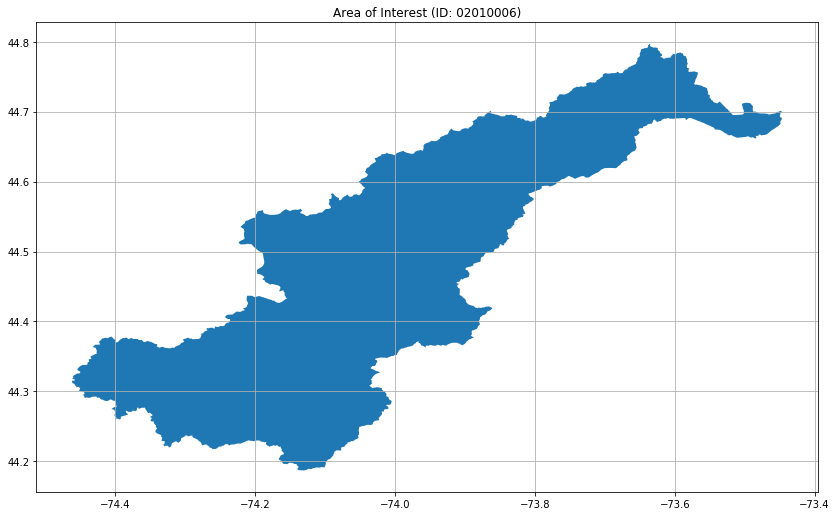

In [7]:
gdf_slice = gdf.loc[gdf[filter_field]==select_data].copy()

gdf_slice.crs = vector_crs_prj

geo_df = gdf_slice.to_crs(crs = noaa_data_crs)

plot_area_of_interest(geo_df, select_data, gdf_slice_column)

## Retrieve the Precipitation Frequency Data:

### Get list of zip files:

In [8]:
noaa_url = 'ftp://hdsc.nws.noaa.gov/pub/hdsc/data/{}/'.format(volume_key[volume])

req = urllib.request.Request(noaa_url)
data = urllib.request.urlopen(req).read().decode().split()

copy_zips = []
for duration in durations:
    zips = [d for d in data if ('.zip' in d) and ('{}'.format(duration) in d) and ('ams' not in d)]
    copy_zips.append(zips)
    print('{} files found for {}'.format(len(zips), duration))

all_zips_list = list(np.array(copy_zips).flat)

30 files found for 06h
30 files found for 12h
30 files found for 24h
30 files found for 04d


### Iterate through zip files and build a table:

In [9]:
start = time.time()
results = []
print_zips=True
for i, zip_name in enumerate(all_zips_list):
    
    remote_file = os.path.join(noaa_url, zip_name)
    try:
        
        open_socket = urllib.request.urlopen(remote_file)   
        memfile = io.BytesIO(open_socket.read())

        with ZipFile(memfile, 'r') as openzip:
            gridfiles = openzip.namelist()
            assert len(gridfiles) == 1,'Expected to find 1 file, found {}'.format(len(gridfiles))
            local_file = gridfiles[0]

            f = openzip.open(local_file)
            content = f.read() 

            local_file_to_disk = os.path.join(os.getcwd(), local_file)

            with open(local_file_to_disk, 'wb') as asc:
                asc.write(content)

        grid_data = parse_filename(zip_name, volume_key[volume])
        grid_data['value'] = get_masked_mean_atlas14(geo_df, local_file_to_disk)    
        results.append(grid_data)

        os.remove(local_file_to_disk)
        if print_zips: print(i, zip_name)
        
    except:
        print("Unable to get data for {}...may be the result of a poor connection".format(zip_name))
        
print(round(time.time()-start), 'Seconds')

0 ne1000yr06ha.zip
1 ne1000yr06hal.zip
2 ne1000yr06hau.zip
3 ne100yr06ha.zip
4 ne100yr06hal.zip
5 ne100yr06hau.zip
6 ne10yr06ha.zip
7 ne10yr06hal.zip
8 ne10yr06hau.zip
9 ne1yr06ha.zip
10 ne1yr06hal.zip
11 ne1yr06hau.zip
12 ne200yr06ha.zip
13 ne200yr06hal.zip
14 ne200yr06hau.zip
15 ne25yr06ha.zip
16 ne25yr06hal.zip
17 ne25yr06hau.zip
18 ne2yr06ha.zip
19 ne2yr06hal.zip
20 ne2yr06hau.zip
21 ne500yr06ha.zip
22 ne500yr06hal.zip
23 ne500yr06hau.zip
24 ne50yr06ha.zip
25 ne50yr06hal.zip
26 ne50yr06hau.zip
27 ne5yr06ha.zip
28 ne5yr06hal.zip
29 ne5yr06hau.zip
30 ne1000yr12ha.zip
31 ne1000yr12hal.zip
32 ne1000yr12hau.zip
33 ne100yr12ha.zip
34 ne100yr12hal.zip
35 ne100yr12hau.zip
36 ne10yr12ha.zip
37 ne10yr12hal.zip
38 ne10yr12hau.zip
39 ne1yr12ha.zip
40 ne1yr12hal.zip
41 ne1yr12hau.zip
42 ne200yr12ha.zip
43 ne200yr12hal.zip
44 ne200yr12hau.zip
45 ne25yr12ha.zip
46 ne25yr12hal.zip
47 ne25yr12hau.zip
48 ne2yr12ha.zip
49 ne2yr12hal.zip
50 ne2yr12hau.zip
51 ne500yr12ha.zip
52 ne500yr12hal.zip
53 ne50

## Save the Results:

### Create an outputs directory:

In [10]:
if not os.path.isdir(outputs_dir):
    os.mkdir(outputs_dir)

### Transform the data to a dataframe and save:

In [11]:
df = pd.DataFrame.from_dict(results)

writer = pd.ExcelWriter(outputs_dir/'PrecipTable_{}.xlsx'.format(select_data))

for i, d in enumerate(durations):
    table = pd.pivot_table(df[df['duration']==d], values = 'value', index=['TR'], columns=['statistic'])
    table.index.name='Tr'
    table.columns.name = None
    table = table.sort_values(by=['Expected Value'])
    table.to_excel(writer, sheet_name='AreaDepths_{}'.format(dur_names[i]))
    print(table)
    
writer.save()

      Expected Value  Lower (90%)  Upper (90%)
Tr                                            
1           1.402850     1.148532     1.702089
2           1.680928     1.374522     2.041564
5           2.135597     1.739553     2.602149
10          2.512793     2.033436     3.078254
25          3.031982     2.365180     3.880254
50          3.420349     2.607081     4.471436
100         3.832415     2.826416     5.200728
200         4.308613     2.979932     5.949647
500         5.007066     3.314275     7.149201
1000        5.589311     3.601647     8.135424
      Expected Value  Lower (90%)  Upper (90%)
Tr                                            
1           1.687509     1.390980     2.033393
2           2.000067     1.646528     2.412450
5           2.511113     2.059148     3.038385
10          2.935034     2.391054     3.569929
25          3.518568     2.762640     4.461597
50          3.955944     3.034154     5.119961
100         4.418208     3.276744     5.926685
200         4

---

# END